## Real Stock Portfolio Optimization (VQE - Fractional Ansatz)

This example notebook uses a **Variational Quantum Eigensolver (VQE)** with a **fractional ansatz** to optimize a portfolio of real stocks (AAPL, MSFT, GOOGL, AMZN).

### Key Highlights:
- **Live data** from Yahoo Finance (`yfinance`)
- **Fractional weights** encoded via RY rotations:  
  $w_i = \sin^2(\theta_i / 2)$
- **Cost function** balances return, risk, and budget constraint:
  $\text{Cost} = -\mu^T w + q \cdot w^T \Sigma w + \text{penalty}$
- **Outputs**: Final weights, convergence plot, bar and pie charts.

This example shows how quantum circuits can solve real-world finance problems using hybrid quantum-classical methods.

In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath("../.."))
from Real_Stock_Data import get_stock_data

In [7]:
# Problem setup
q = 0.5  # Risk aversion parameter
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
mu, Sigma, prices = get_stock_data(tickers, start="2023-01-01", end="2024-01-01")
n_assets = len(mu)

/workspaces/VQE_Portfolio_Optimization/Real_Stock_Data.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, group_by="ticker", progress=False)


In [8]:
dev = qml.device("default.qubit", wires=n_assets)


# Convert RY angles to weights (probability of measuring |1⟩)
def weights_from_thetas(thetas):
    return np.sin(thetas / 2) ** 2


@qml.qnode(dev)
def circuit(thetas):
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]


def cost_fn(thetas):
    weights = weights_from_thetas(thetas)
    expected_return = np.dot(mu, weights)
    risk = np.dot(weights, np.dot(Sigma, weights))
    penalty = 10 * (np.sum(weights) - 1.0) ** 2  # Encourage total weight = 1
    return -expected_return + q * risk + penalty


def run_vqe():
    thetas = np.random.uniform(0, np.pi, n_assets, requires_grad=True)
    opt = AdamOptimizer(0.1)
    steps = 100
    costs = []

    for _ in range(steps):
        thetas = opt.step(cost_fn, thetas)
        costs.append(cost_fn(thetas))
    
    final_cost = costs[-1]
    weights = weights_from_thetas(thetas)
    weights /= np.sum(weights)  # normalize
    return final_cost, weights

best_cost = np.inf
best_weights = None
runs = 50  # or more

for i in range(runs):
    cost, weights = run_vqe()
    if i % 5 == 4:
        print(f"Run {i+1} | Final Cost: {cost:.4f}")
    if cost < best_cost:
        best_cost = cost
        best_weights = weights


Run 5 | Final Cost: -0.3006
Run 10 | Final Cost: -0.2445
Run 15 | Final Cost: -0.1915
Run 20 | Final Cost: -0.3995
Run 25 | Final Cost: -0.2531
Run 30 | Final Cost: -0.3318
Run 35 | Final Cost: -0.3441
Run 40 | Final Cost: -0.1845
Run 45 | Final Cost: -0.1486
Run 50 | Final Cost: -0.1707


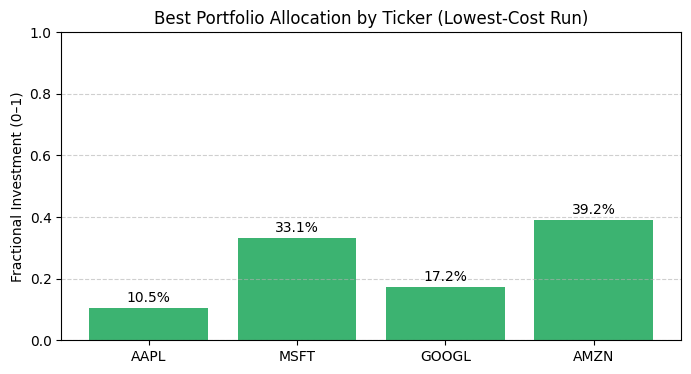

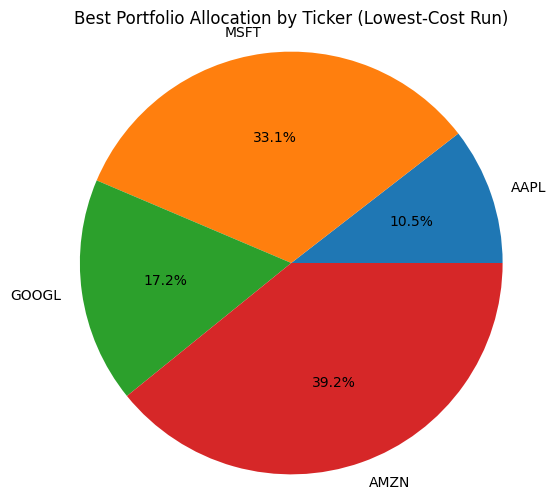

In [ ]:
qubits_per_asset = len(best_weights) // len(tickers)
n_assets = len(tickers)

aggregated_weights = []

for i in range(n_assets):
    start = i * qubits_per_asset
    end = (i + 1) * qubits_per_asset
    total_weight = np.sum(best_weights[start:end])
    aggregated_weights.append(total_weight)

aggregated_weights = np.array(aggregated_weights)
aggregated_weights = aggregated_weights / np.sum(aggregated_weights)

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(tickers, aggregated_weights, color='mediumseagreen')
plt.title("Best Portfolio Allocation by Ticker (Lowest-Cost Run)")
plt.ylabel("Fractional Investment (0–1)")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
for i, w in enumerate(aggregated_weights):
    plt.text(i, w + 0.02, f"{w * 100:.1f}%", ha='center', fontsize=10)
plt.show()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(aggregated_weights, labels=tickers, autopct='%1.1f%%')
plt.title("Best Portfolio Allocation by Ticker (Lowest-Cost Run)")
plt.axis("equal")
plt.show()